In [6]:
# Dependencies

import pandas as pd
import os
import pathlib
from pathlib import Path
import glob
import seaborn as sns
import pickle
import boto3

In [7]:
from sagemaker import get_execution_role
role = get_execution_role

In [13]:
bucket = 'ads508-team1'
subfolder = ''
# path = ## ADD s3 path
# s3client = boto3.client('s3')
# response = s3client.get_object(Bucket=bucket, Key=path)
# body = response['Body']

# data = pickle.loads(body.read())

In [19]:
# Import CSVs as a list of dataframes

path = Path('./data/')
csv_files = glob.glob(os.path.join(path, "*.csv"))
df_list = [pd.read_csv(file) for file in csv_files]

## Exploratory Analysis

### File Discovery

In [20]:
# List of CSV file names

csv_names = ['serv_calls_22', 'disp_codes', 'call_codes', 'beat_codes', 'serv_calls_23']

In [21]:
def get_byte_size(df):
    ''' Takes a dataframe and converts its byte size to KB. '''
    k_bytes = round(df.memory_usage(index=True).sum() / 1000, 2)
    return k_bytes

In [22]:
# Dictionary of CSV file sizes

byte_dict = {k: f"{get_byte_size(i)} kb" for i,k in zip(df_list, csv_names)}
byte_dict

{'serv_calls_22': '10418.03 kb',
 'disp_codes': '2.13 kb',
 'call_codes': '0.42 kb',
 'beat_codes': '11.69 kb',
 'serv_calls_23': '55916.8 kb'}

In [36]:
# Rename input dataframes

serv_calls_23 = df_list[0]
beat_codes = df_list[1]
disp_codes = df_list[2]
call_codes = df_list[3]
serv_calls_22 = df_list[4]

In [37]:
# Assign Names to Service Call dataframes
serv_calls_22.name = 'Service Calls 2022'
serv_calls_23.name = 'Service Calls 2023'

### Service Call Table Examination

#### Service Calls '22

In [38]:
serv_calls_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499256 entries, 0 to 499255
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   incident_num               499256 non-null  object 
 1   date_time                  499256 non-null  object 
 2   day_of_week                499256 non-null  int64  
 3   address_number_primary     499256 non-null  int64  
 4   address_dir_primary        23135 non-null   object 
 5   address_road_primary       499187 non-null  object 
 6   address_sfx_primary        455019 non-null  object 
 7   address_dir_intersecting   0 non-null       float64
 8   address_road_intersecting  85382 non-null   object 
 9   address_sfx_intersecting   0 non-null       float64
 10  call_type                  498640 non-null  object 
 11  disposition                497161 non-null  object 
 12  beat                       499256 non-null  int64  
 13  priority                   49

In [39]:
serv_calls_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93017 entries, 0 to 93016
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   incident_num               93017 non-null  object 
 1   date_time                  93017 non-null  object 
 2   day_of_week                93017 non-null  int64  
 3   address_number_primary     93017 non-null  int64  
 4   address_dir_primary        4504 non-null   object 
 5   address_road_primary       93005 non-null  object 
 6   address_sfx_primary        84748 non-null  object 
 7   address_dir_intersecting   0 non-null      float64
 8   address_road_intersecting  15173 non-null  object 
 9   address_sfx_intersecting   0 non-null      float64
 10  call_type                  92929 non-null  object 
 11  disposition                92738 non-null  object 
 12  beat                       93017 non-null  int64  
 13  priority                   93017 non-null  int

In [40]:
# Examining the Primary Address fields
adp_df = pd.DataFrame({'adp': [], 'adp_len': []})

adp_df['anp'] = serv_calls_22['address_number_primary'].where(serv_calls_22['address_dir_primary'].notnull())
adp_df['adp'] = serv_calls_22['address_dir_primary'].dropna(axis=0, inplace=False)
adp_df['adp_len'] = adp_df['adp'].str.len()
adp_df['arp'] = serv_calls_22['address_road_primary'].where(serv_calls_22['address_dir_primary'].notnull())
adp_df['asp'] = serv_calls_22['address_sfx_primary'].where(serv_calls_22['address_dir_primary'].notnull())

adp_df.dropna(inplace=True)

In [41]:
adp_df.head()

,adp,adp_len,anp,arp,asp
66,S,1.0,400.0,46TH,ST
191,S,1.0,900.0,30TH,ST
209,S,1.0,0.0,30TH,ST
219,E,1.0,700.0,SAN YSIDRO,BLV
244,S,1.0,0.0,FRANCIS,ST


In [42]:
# Examining the Intersecting Address fields
aip_df = pd.DataFrame({})

aip_df['adi'] = serv_calls_22['address_road_intersecting'].dropna(axis=0, inplace=False)
aip_df['ari'] = serv_calls_22['address_dir_intersecting'].where(serv_calls_22['address_road_intersecting'].notnull())
aip_df['asi'] = serv_calls_22['address_sfx_intersecting'].where(serv_calls_22['address_road_intersecting'].notnull())

aip_df.dropna(inplace=True)

In [43]:
aip_df.head()

,adi,ari,asi


In [44]:
def count_missing(df):
    ''' Count number of missing values for each DF column '''
    na_nums = df.isna().sum()
    na_plot = na_nums.reset_index(name="Count").plot.bar(x='index', y='Count', title='Service Calls', rot=90)
    
    return na_nums, na_plot

(incident_num                      0
 date_time                         0
 day_of_week                       0
 address_number_primary            0
 address_dir_primary          476121
 address_road_primary             69
 address_sfx_primary           44237
 address_dir_intersecting     499256
 address_road_intersecting    413874
 address_sfx_intersecting     499256
 call_type                       616
 disposition                    2095
 beat                              0
 priority                          0
 dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22027260d0>)

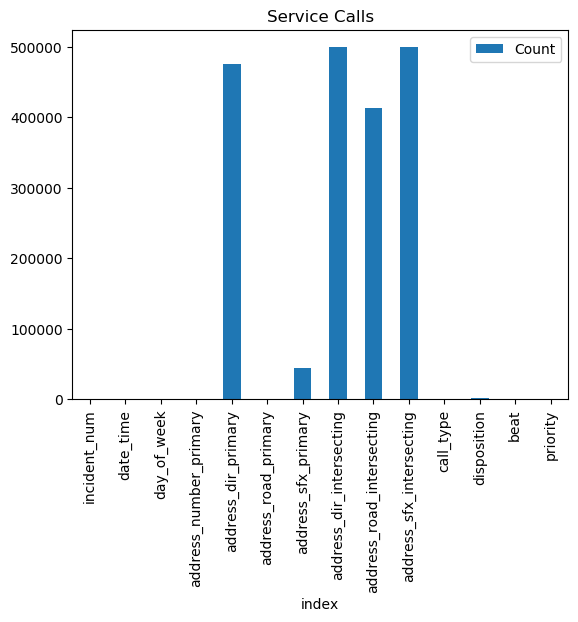

In [45]:
%matplotlib inline 
count_missing(serv_calls_22)

(incident_num                     0
 date_time                        0
 day_of_week                      0
 address_number_primary           0
 address_dir_primary          88513
 address_road_primary            12
 address_sfx_primary           8269
 address_dir_intersecting     93017
 address_road_intersecting    77844
 address_sfx_intersecting     93017
 call_type                       88
 disposition                    279
 beat                             0
 priority                         0
 dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f220283a610>)

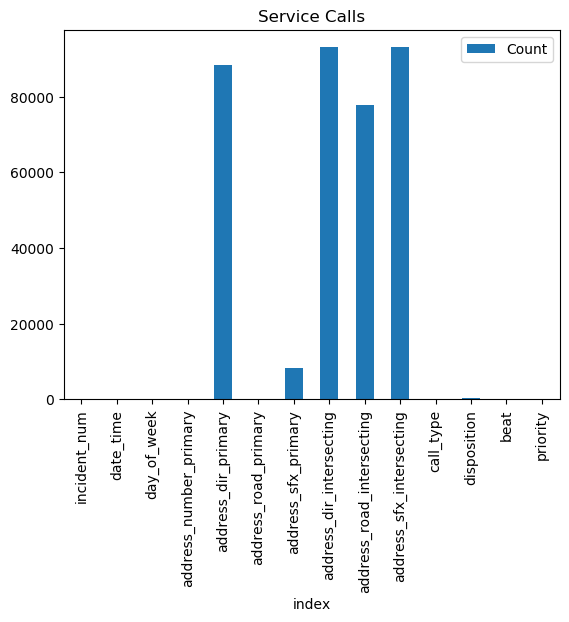

In [46]:
%matplotlib inline 
count_missing(serv_calls_23)

In [47]:
# List all the neighborhoods in San Diego

beat_codes['neighborhood'].unique()

array(['Clairemont Mesa East', 'Clairemont Mesa West', 'Bay Ho',
       'North Clairemont', 'University City', 'Bay Park', 'Mission Beach',
       'Pacific Beach', 'Mission Bay Park', 'La Jolla', 'Torrey Pines',
       'Sabre Springs', 'Carmel Mountain', 'Rancho Penasquitos',
       'Rancho Bernardo', 'San Pasqual', 'Scripps Ranch', 'Mira Mesa',
       'Miramar', 'Rancho Encantada', 'Miramar Ranch North', 'Serra Mesa',
       'Tierrasanta', 'Kearny Mesa', 'Birdland', 'Mission Valley East',
       'Qualcomm', 'Grantville', 'Allied Gardens', 'Del Cerro',
       'Lake Murray', 'San Carlos', 'College West', 'College East',
       'Emerald Hills', 'Valencia Park', 'Encanto', 'Jamacha/Lomita',
       'Broadway Heights', 'Skyline', 'Bay Terraces', 'Paradise Hills',
       'Alta Vista', 'Mountain View', 'Southcrest', 'Shelltown',
       'Mt. Hope', 'Chollas View', 'Lincoln Park', 'Ridgeview/Webster',
       'Oak Park', "O'Farrell", 'Barrio Logan', 'Logan Heights',
       'Sherman Heights', 'Gr

In [48]:
# List all the neighborhoods in San Diego

call_codes['description'].unique()

array(['PRISONER IN CUSTODY', 'PTU (PRISONER TRANSPORT)',
       'SHOPLIFTER/QUICK CITE', 'PHONE YOUR STATION', 'PHONE YOUR HOME',
       'AUTO THEFT', 'EVAL-POSS UNREPORTED CAR THEFT', 'CAR THEFT REPORT',
       'CAR THEFT RECOVERY REPORT', 'TAMPERING W/VEH IN PROGRESS',
       'VEHICLE ALARM/AUDIBLE', 'VEHICLE CASER', 'TAMPERING W/VEH REPORT',
       'MEET OFFICER NON URGENT', 'DISCHARGING FIREARMS',
       'DISCHARGING FIREARM SHOT SPOTTER ACTIVATION', 'PROWLER',
       'PERSON DOWN', 'REPORT OF CRIME OCCD MEXICO', 'CHECK THE AREA',
       'BALL GAME IN STREET(83 03MC)', 'INCOMPLETE PHONE CALL',
       'CALLING FOR HELP', 'CALLING FOR HELP-PANIC ALARM',
       'AMBULANCE CALL, OVERDOSE', 'AMBULANCE NEEDED', "CORONER'S CASE",
       'REPORT OF DEATH', 'INJURED PERSON', 'FURNISH TRANSPORTATION',
       'TRAFFIC STOP/NO LICENSE', 'TRAFFIC STOP/WITH LICENSE',
       'PED STOP/FIELD INTERVIEW', 'SECURITY CHECK',
       'HAZARDOUS/CHEMICAL SPILL', 'INVESTIGATE WATER LEAK',
       'SIGNALS

Selected Call Type Codes

* 5150 - Mental Health
* 5150V - Mental Health - Violent or Urgent
* FS - Found Senile
* Rescue - Rescue Citizens

In [49]:
# Call Type Codes related to substance abuse, mental health, suicide

crisis_response = ['5150', '5150V', 'FS', 'RESCUE']

# Select Rows containing these call type codes
cr_df = serv_calls_22[serv_calls_22['call_type'].isin(crisis_response)]

In [67]:
# Look into distribution of call types related to substance abuse, mental health, and suicide response


# sns.histplot(data = cr_df, x = 'call_type')

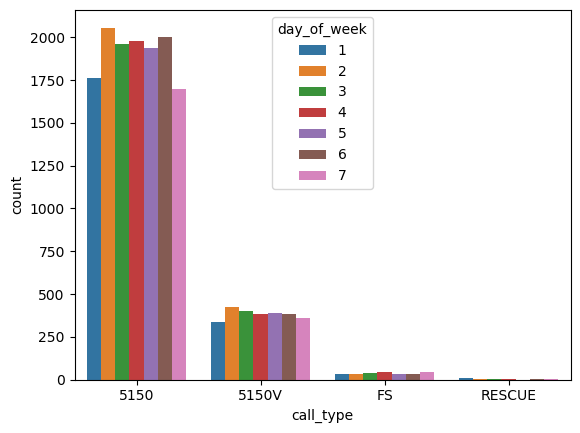

In [51]:
# Look into if calls fluctuate based on the day of week

sns.countplot(x= 'call_type', hue = 'day_of_week', data = cr_df)

In [52]:
# Show Number of Call Types for the crisis response codes

cr_df['call_type'].value_counts().to_frame()

,call_type
5150,13406
5150V,2676
FS,261
RESCUE,24


In [53]:
# Find which neighborhoods have the most call

cr_df['beat'].value_counts().to_frame()

,beat
521,1220
524,666
627,521
242,454
122,389
...,...
617,4
435,3
235,1
0,1


In [54]:
beat_codes.dtypes

beat             int64
neighborhood    object
dtype: object

In [55]:
# Find which neighborhoods have the highest calls

top_areas_of_cf_calls = [521, 524, 627, 242, 122]

print(beat_codes[beat_codes['beat'].isin(top_areas_of_cf_calls)])

    beat   neighborhood
7    122  Pacific Beach
17   242      Mira Mesa
59   521   East Village
62   524  Core-Columbia
84   627      Hillcrest


In [57]:
# Group by General Neighborhood Areas for Better Visualization
b_codes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
b_neighborhoods = ['100s', '200s', '300s', '400s', '500s', '600s', '700s', '800s', '900s']

cr_df['grouped_neighborhoods'] = pd.cut(cr_df['beat'], bins = b_codes, labels = b_neighborhoods, include_lowest = True)
cr_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority,grouped_neighborhoods
138,E22010000145,2022-01-01 01:11:19,7,3200,NaN,COWLEY,WAY,NaN,NaN,NaN,5150,CAN,116,2,100s
172,E22010000183,2022-01-01 01:33:06,7,9100,NaN,HUNTINGTON,AVE,NaN,NaN,NaN,5150V,K,311,1,300s
177,E22010000188,2022-01-01 01:38:21,7,900,NaN,05TH,AVE,NaN,NaN,NaN,5150,CAN,523,2,500s
223,E22010000237,2022-01-01 02:13:26,7,6700,NaN,THORNWOOD,ST,NaN,NaN,NaN,5150,K,111,2,100s
329,E22010000350,2022-01-01 03:34:26,7,2000,NaN,VESTA,ST,NaN,NaN,NaN,5150,CAN,511,2,500s


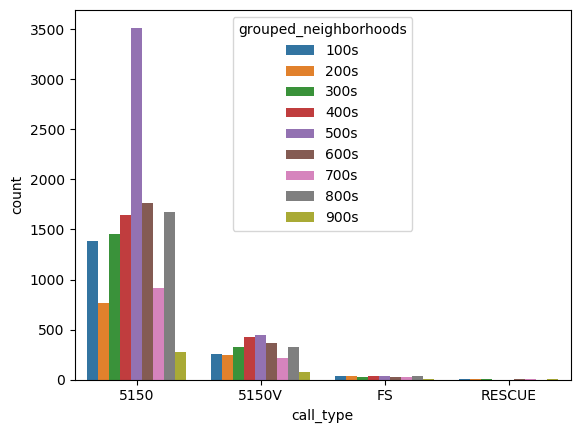

In [58]:
# Call Types by Grouped Neighborhoods 

sns.countplot(x= 'call_type', hue = 'grouped_neighborhoods', data = cr_df)

In [68]:
# Distribution of Calls by Neighborhoods

# sns.histplot(data = cr_df, x = 'grouped_neighborhoods')

Downtown San Diego, specifically in East Village has the highest calls related to substance abuse, mental health, and suicide response.